In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import tensorflow as tf
import tensorflow_hub as hub
import torch
import os
import json
import re
#import fairseq

#from fairseq.models.roberta import RobertaModel
from pytorch_transformers import WEIGHTS_NAME, CONFIG_NAME
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from datetime import datetime as dt
from dateutil import tz

In [56]:
torch.__version__

'1.2.0'

```from pytorch_transformers import WEIGHTS_NAME, CONFIG_NAME
output_dir = "./models/"```

### Step 1: Save a model, configuration and vocabulary that you have fine-tuned

### If we have a distributed model, save only the encapsulated model
### (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
`model_to_save = model.module if hasattr(model, 'module') else model`

### If we save using the predefined names, we can load using `from_pretrained`
```output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)```

### Step 2: Re-load the saved model and vocabulary

### Example for a Bert model
```model = BertForQuestionAnswering.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir, do_lower_case=args.do_lower_case)```
### Example for a GPT model
```model = OpenAIGPTDoubleHeadsModel.from_pretrained(output_dir)
tokenizer = OpenAIGPTTokenizer.from_pretrained(output_dir)```


```from pytorch_transformers import BertModel, BertTokenizer, BertConfig
import torch
enc = BertTokenizer.from_pretrained("bert-base-uncased")```

### Tokenizing input text
```text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = enc.tokenize(text)```

### Masking one of the input tokens
```masked_index = 8
tokenized_text[masked_index] = '[MASK]'
indexed_tokens = enc.convert_tokens_to_ids(tokenized_text)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]```

### Creating a dummy input
```tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
dummy_input = [tokens_tensor, segments_tensors]```

### Initializing the model with the torchscript flag
### Flag set to True even though it is not necessary as this model does not have an LM Head.
```config = BertConfig(vocab_size_or_config_json_file=32000, hidden_size=768,
    num_hidden_layers=12, num_attention_heads=12, intermediate_size=3072, torchscript=True)```

### Instantiating the model
`model = BertModel(config)`

### The model needs to be in evaluation mode
`model.eval()`

### If you are instantiating the model with `from_pretrained` you can also easily set the TorchScript flag
`model = BertModel.from_pretrained("bert-base-uncased", torchscript=True)`

### Creating the trace
```traced_model = torch.jit.trace(model, [tokens_tensor, segments_tensors])
torch.jit.save(traced_model, "traced_bert.pt")```

### Loading
```loaded_model = torch.jit.load("traced_model.pt")
loaded_model.eval()
all_encoder_layers, pooled_output = loaded_model(dummy_input)```


### Inferring
`traced_model(tokens_tensor, segments_tensors)`


`tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', unk_token='<unk>')`
You should be sure `'<unk>'` is in the vocabulary when doing that.
Otherwise use `tokenizer.add_special_tokens({'unk_token': '<unk>'})` instead)


In [2]:
csv_path = 'dadjokes-subreddit-archive/data_redditdadjokes.csv'
dj = pd.read_csv(csv_path, na_values=["[deleted]", "",'N/A'], index_col=0, sep='|')
dj

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments
id,,,,,,,
cvxjgm,1566869903,NaN,crash8308,A co-worker of mine just had a successful surg...,...but they were all tasteless.\n\nNo really h...,1,0
cvxfms,1566869365,NaN,EmmyFromKansas,I have a step-ladder. My real ladder left when...,NaN,1,0
cvxdb0,1566869039,NaN,Elruler22,What do you call a smart terminator,A determinator,1,1
cvxbhg,1566868780,NaN,PossiblyDumb66,I was rejected from the astronaut academy,I guess the sky is my limit,1,0
cvx9ta,1566868551,NaN,sleepcow,What’s smarter than a talking parrot?,A spelling bee,1,0
...,...,...,...,...,...,...,...
142cgr,1354302640,NaN,NaN,Why do you always bang girls with big asses?,So your balls don't touch the floor,2,0
lnx9i,1319510948,NaN,tali3sin,What's brown and sticky?,A stick.,5,0
lnx31,1319510661,NaN,tali3sin,Why doesn't the Queen wave with this hand?,NaN,3,0


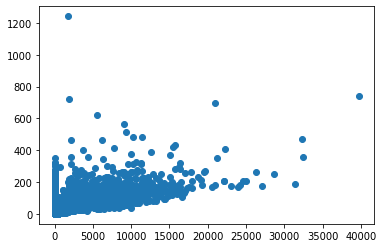

In [36]:
plt.scatter(dj.score, dj.num_comments)

(array([7.7535e+04, 6.2458e+04, 1.4686e+04, 1.9510e+03, 1.3290e+03,
        8.4100e+02, 7.0000e+00]),
 array([   0,    1,    5,   20,   50,  100,  500, 1500]),
 <a list of 7 Patch objects>)

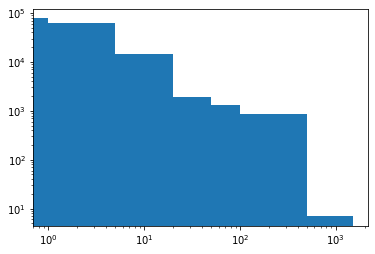

In [34]:
plt.xscale('log')
plt.yscale('log')
plt.hist(dj.num_comments, bins=[0,1,5,20,50,100,500,1500])

(array([18793., 68271., 42265., 14288.,  5855.,  5574.,  3761.]),
 array([    0,     1,     5,    20,    50,   100,   500, 40000]),
 <a list of 7 Patch objects>)

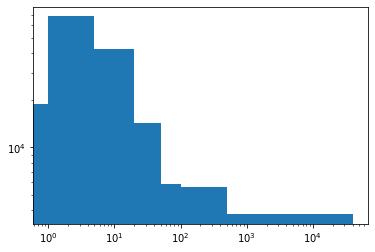

In [33]:
plt.xscale('log')
plt.yscale('log')
plt.hist(dj.score, bins=[0,1,5,20,50,100,500,40000])

In [5]:
dj.isna().sum()

createdUTC                0
parent_createdUTC    158199
author                14417
title                     3
selftext              14211
score                     0
num_comments              0
dtype: int64

In [6]:
dj.selftext.iloc[0]

'...but they were all tasteless.\\n\\nNo really he’s recovering well and I hope I don’t get fired now.'

In [7]:
dj['is_crosspost'] = ~dj['parent_createdUTC'].isna()
dj

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments,is_crosspost
id,,,,,,,,
cvxjgm,1566869903,NaN,crash8308,A co-worker of mine just had a successful surg...,...but they were all tasteless.\n\nNo really h...,1,0,False
cvxfms,1566869365,NaN,EmmyFromKansas,I have a step-ladder. My real ladder left when...,NaN,1,0,False
cvxdb0,1566869039,NaN,Elruler22,What do you call a smart terminator,A determinator,1,1,False
cvxbhg,1566868780,NaN,PossiblyDumb66,I was rejected from the astronaut academy,I guess the sky is my limit,1,0,False
cvx9ta,1566868551,NaN,sleepcow,What’s smarter than a talking parrot?,A spelling bee,1,0,False
...,...,...,...,...,...,...,...,...
142cgr,1354302640,NaN,NaN,Why do you always bang girls with big asses?,So your balls don't touch the floor,2,0,False
lnx9i,1319510948,NaN,tali3sin,What's brown and sticky?,A stick.,5,0,False
lnx31,1319510661,NaN,tali3sin,Why doesn't the Queen wave with this hand?,NaN,3,0,False


In [8]:
dj.groupby(by='is_crosspost').mean()

,createdUTC,parent_createdUTC,score,num_comments
is_crosspost,,,,
False,1.493832e+09,NaN,91.532949,3.318536
True,1.544029e+09,1.543531e+09,2.574013,0.351974


### Crossposts receive significantly lower scores, num_comments than original posts in the dadjokes subreddit. This may be because viewers are easily redirected to the parent post to comments or upvote in other areas of reddit. However, the contents of the crossposted jokes (title and selftext) are pulled from the parent posts. Therefore crossposts will be analyzed separately when attempting to predict scores, num_comments.

In [9]:
main = dj[~dj.is_crosspost].drop(columns=['parent_createdUTC', 'is_crosspost'])
main

,createdUTC,author,title,selftext,score,num_comments
id,,,,,,
cvxjgm,1566869903,crash8308,A co-worker of mine just had a successful surg...,...but they were all tasteless.\n\nNo really h...,1,0
cvxfms,1566869365,EmmyFromKansas,I have a step-ladder. My real ladder left when...,NaN,1,0
cvxdb0,1566869039,Elruler22,What do you call a smart terminator,A determinator,1,1
cvxbhg,1566868780,PossiblyDumb66,I was rejected from the astronaut academy,I guess the sky is my limit,1,0
cvx9ta,1566868551,sleepcow,What’s smarter than a talking parrot?,A spelling bee,1,0
...,...,...,...,...,...,...
142cgr,1354302640,NaN,Why do you always bang girls with big asses?,So your balls don't touch the floor,2,0
lnx9i,1319510948,tali3sin,What's brown and sticky?,A stick.,5,0
lnx31,1319510661,tali3sin,Why doesn't the Queen wave with this hand?,NaN,3,0


In [52]:
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large', force_reload=True, pretrained=True)

Downloading: "https://github.com/pytorch/fairseq/archive/master.zip" to /Users/joannejordan/.cache/torch/hub/master.zip


TypeError: 'NoneType' object is not iterable

In [14]:
train, test = train_test_split(main, test_size=0.2, random_state=42)
print(f"Training sample size: {len(train)}\nTesting sample size: {len(test)}")

Training sample size: 126559
Testing sample size: 31640


### Preparing the data

In [130]:
def _score_cat(val):
    if val == 0:
        return 0
    elif val <= 5:
        return 1
    elif val <= 10:
        return 2
    elif val <= 20:
        return 3
    elif val <=

def prep_df(data):
    data['score_cat'] = 

,createdUTC,parent_createdUTC,author,title,selftext,score,num_comments,is_crosspost
id,,,,,,,,
cuhz4d,1566585505,1.566579e+09,2inchtip1inchshaft,What do you call a Jacuzzi full of resto druids?,A HoT tub\n\nSo excited 3 days left figured i ...,4,0,True
cu6gdv,1566521152,1.566494e+09,Dinoman25,How do you calm your erupting girlfriend?,You shower her with lava and affection,4,0,True
ct6v9y,1566337628,1.566331e+09,scarcityflow,What's E.T. short for?,Because he is got small legs.,1,1,True
ct4hnz,1566328863,1.566298e+09,BigGeak,[WARNING CONTENT NOT FUNNY] Do not click into ...,A horse walked into a bar\n\nBartender: Hey\n...,1,0,True
csqd46,1566261926,1.566261e+09,_just2poorkids,What do you call having a child with a guy cal...,Being gregnant.,1,0,True
...,...,...,...,...,...,...,...,...
7k8o7u,1513449642,1.513449e+09,EricRShelton,A spork is just a tiney spoon,NaN,8,1,True
7jvx09,1513296653,1.513295e+09,Unknown9118,What do you call a team of pets that works tog...,Comcats.,3,0,True
7gmofu,1512052059,1.512051e+09,PM_ME_ORIGIN_CODES,What was the only single that Nihilistic Metal...,Nothing Matters^.^.^I'll^show^myself^out,0,1,True
